### Libraries

In [1]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from scipy.interpolate import interp2d
from scipy.signal import spline_filter, medfilt2d, savgol_filter
from skimage import restoration
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

### SET DIRECTORY HERE

In [2]:
dir = r'C:\Users\physlab\Desktop\August_data\NiFe_2Mode_R'

### Loading Data and Viewing Raw Results


#### *Use the plots to fine the ideal field range such that the signal is not lost

Text(0.5, 1.0, 'Last Signal')

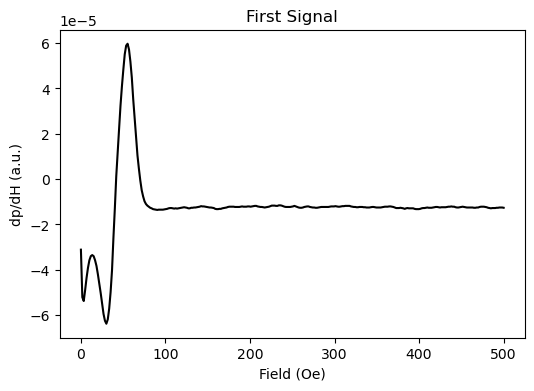

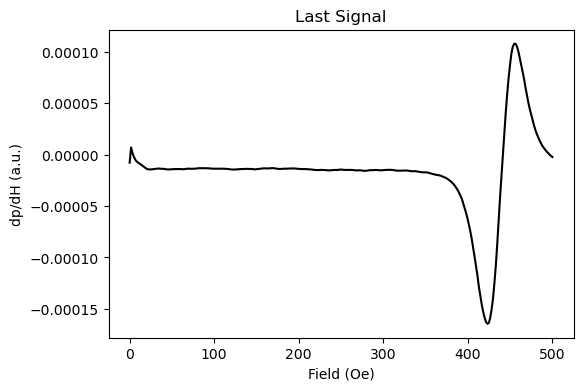

In [3]:
def numOfValues(dir):
    for count in range(10000):
        if os.path.join(dir, os.listdir(dir)[count]).endswith('csv'):
            totalValues = pd.read_csv(os.path.join(dir, os.listdir(dir)[count])).shape[0]
            return totalValues

# Add a dummy row
channel2 = np.zeros(numOfValues(dir))
channel1 = np.zeros(numOfValues(dir))

for file in os.listdir(dir):
    path = os.path.join(dir, file)
    if path.endswith('.csv'):
        df = pd.read_csv(path)
        channel2 = np.row_stack((channel2, df.iloc[:, 3].values))
        channel1 = np.row_stack((channel1, df.iloc[:, 2].values))

# Remove the dummy row
channel2 = channel2[1:][:]
channel1 = channel1[1:][:]

field = df.iloc[:, 1].values
signal = channel2[0][:]
plt.figure(figsize=(6,4))
plt.plot(field, signal, 'k')
plt.xlabel('Field (Oe)')
plt.ylabel('dp/dH (a.u.)')
plt.title('First Signal')

signal = channel2[-1][:]
plt.figure(figsize=(6,4))
plt.plot(field, signal, 'k')
plt.xlabel('Field (Oe)')
plt.ylabel('dp/dH (a.u.)')
plt.title('Last Signal')

### SET FREQUENCY BOUNDS AND INTERVAL HERE

In [4]:
# Important: Change these according to your frequency range [of the original data set]
freq_lowerbound = 2 # minimum value of frequency sweep
freq_upperbound = 6 # maximum value of frequency sweep
interval = 0.1 # frequency interval

# Model Development

In [5]:
# FMR Spectrum Fit Equation
_dp_dh_script = '''
def dp_dh_fitfunct(h, %(prefix)sK1, %(prefix)sK2, %(prefix)sH_FMR, %(prefix)sDH):
    K1 = %(prefix)sK1
    K2 = %(prefix)sK2
    H_FMR = %(prefix)sH_FMR
    DH = %(prefix)sDH
    dh = h - H_FMR
    denom = (DH**2 + dh**2)**2
    return (-K1*2*dh*DH - K2*(DH**2-dh**2))/denom
'''

def dp_dh_model(prefix=''):
    expr = 'dp_dh_fitfunct(x, %(prefix)sK1, %(prefix)sK2, %(prefix)sH_FMR, %(prefix)sDH)' % {'prefix': prefix}
    script = _dp_dh_script % {'prefix': prefix}
    return lmfit.models.ExpressionModel(expr, independent_vars=['x'], init_script=script)

### SET FREQUENCY AND FIELD RANGE THAT YOU WANT TO ANALYZE HERE

In [6]:
# Frequency range that you want to analyze
lower_freq = 2
upper_freq = 6

# Field range that you want to analyze
lower_field = 15
upper_field = 500

In [7]:
channel = channel2

field = df.iloc[:, 1].values
freq = np.linspace(freq_lowerbound, freq_upperbound, channel.shape[0])

def cut_freq(freq, lower_freq, upper_freq):
    lower_freq = math.floor((lower_freq - min(freq))/(max(freq) - min(freq)) * len(freq))
    upper_freq = math.floor((upper_freq - min(freq))/(max(freq) - min(freq)) * len(freq))
    return freq[lower_freq:upper_freq], lower_freq, upper_freq

def cut_field(field, lower_field, upper_field):
    lower_field = math.floor(len(field)/(max(field) - min(field)) * (lower_field - min(field)))
    upper_field = math.floor(len(field)/(max(field) - min(field)) * (upper_field - min(field)))
    return field[lower_field:upper_field], lower_field, upper_field

freq_used = cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = cut_freq(freq, lower_freq, upper_freq)[2]

field_used = cut_field(field, lower_field, upper_field)[0]
lower_field = cut_freq(field, lower_field, upper_field)[1]
upper_field = cut_freq(field, lower_field, upper_field)[2]

### This cell will fit our model on the original data set and show the respective plots.

#### * DON'T FORGET TO CHANGE THE DIRECTORY WHERE THE PLOTS AND PARAMETER FILE IS STORED.

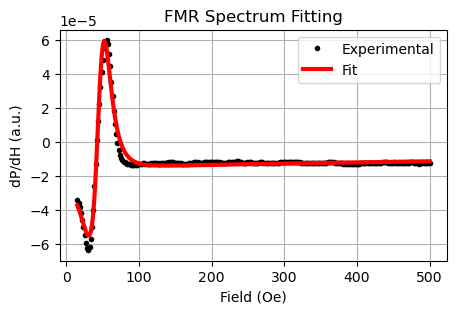

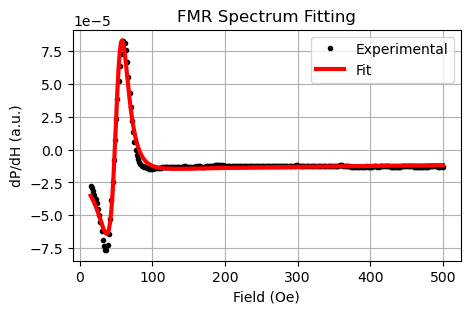

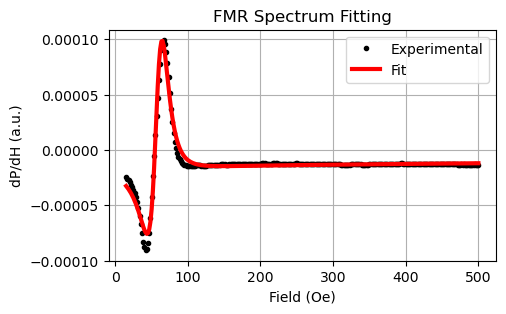

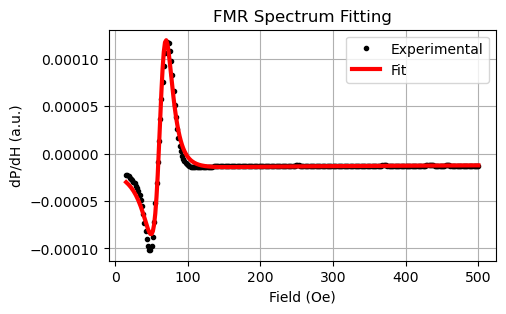

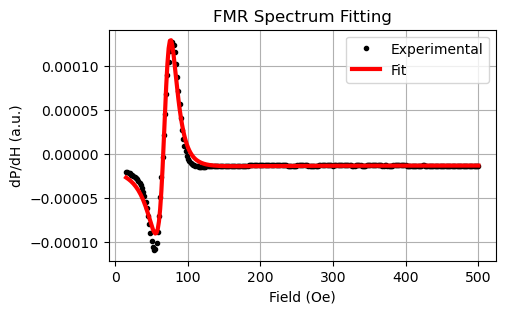

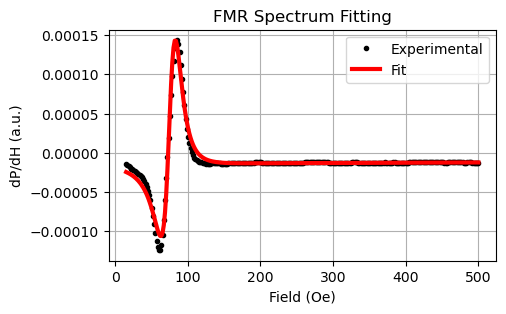

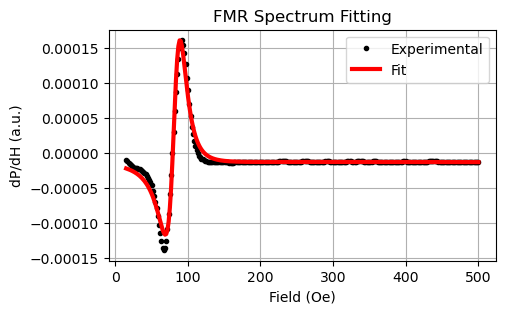

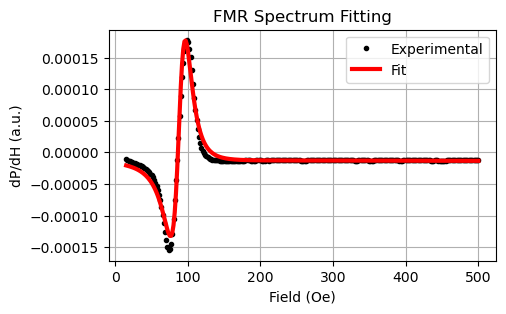

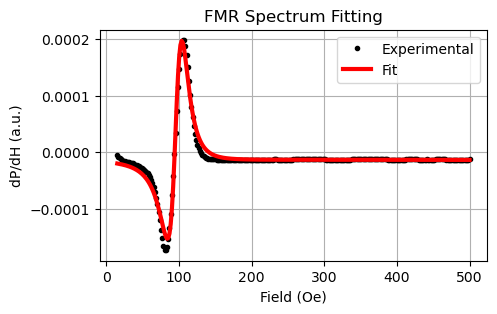

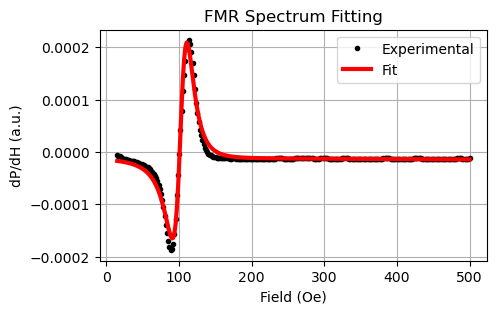

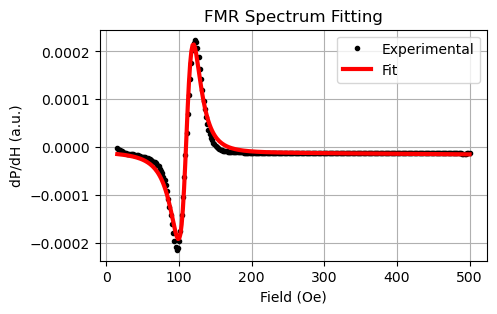

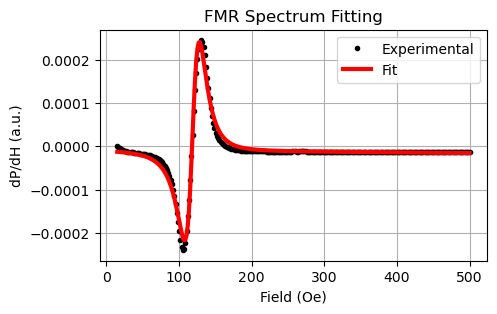

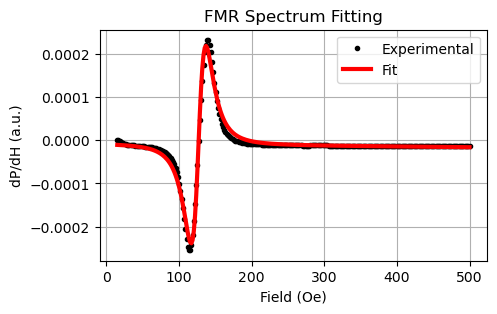

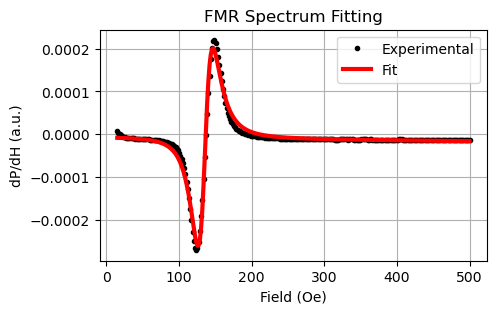

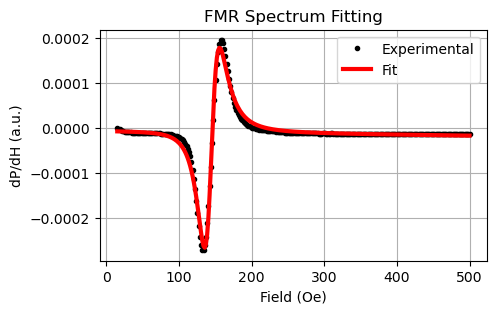

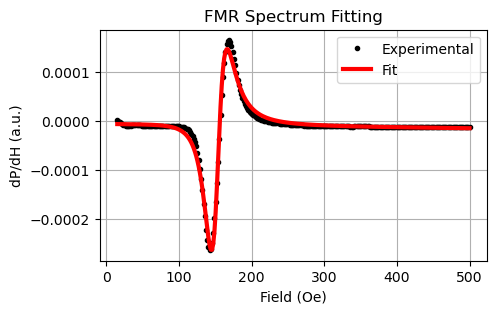

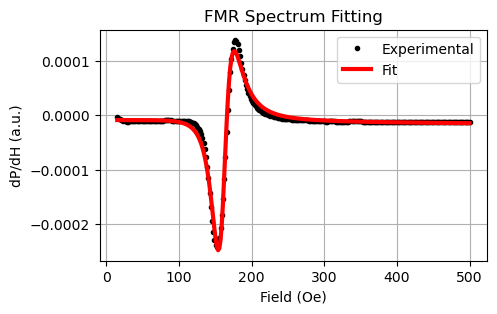

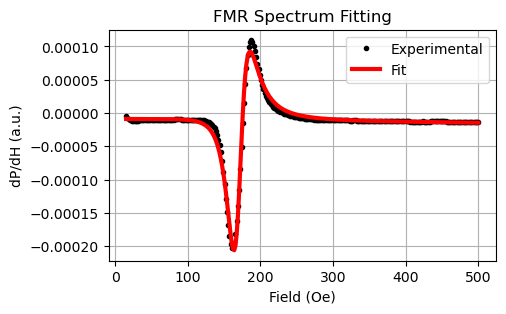

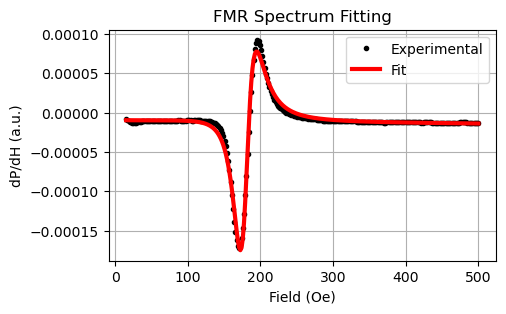

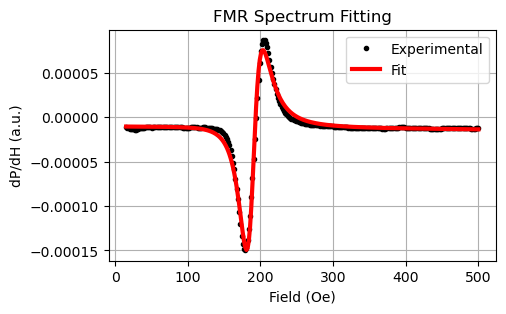

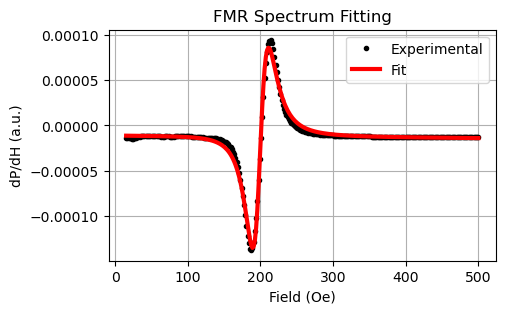

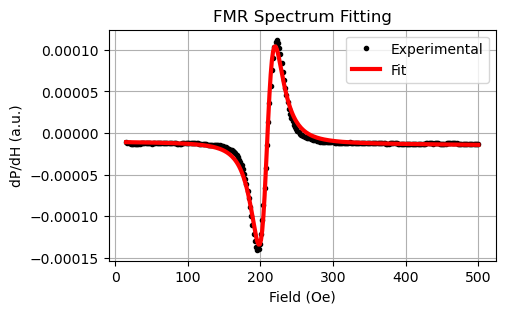

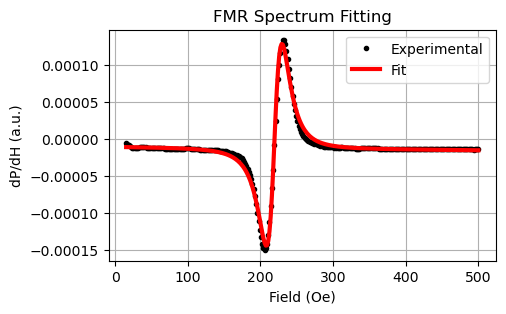

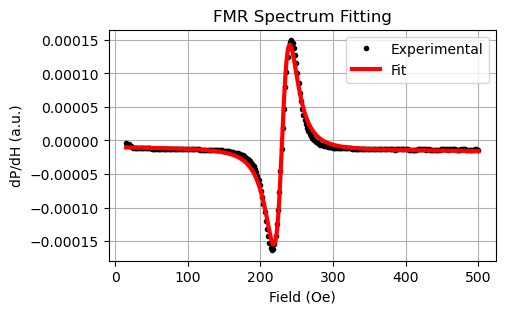

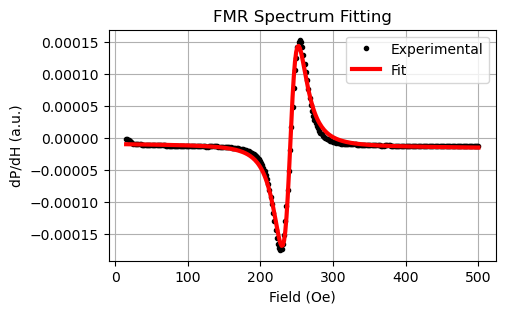

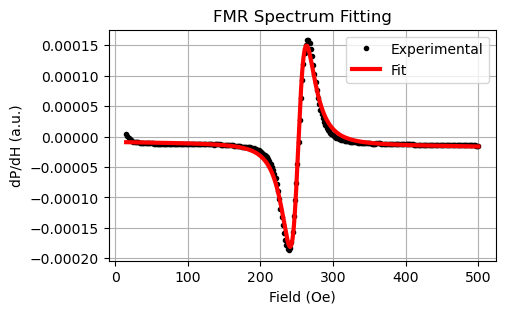

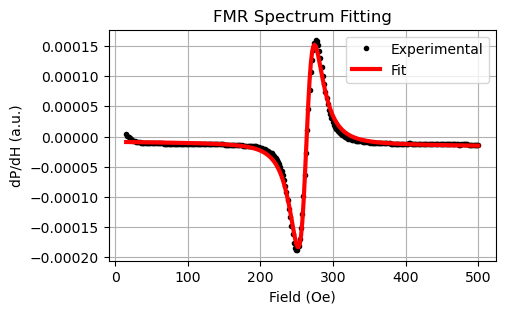

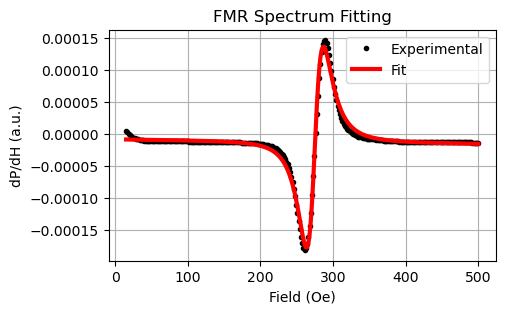

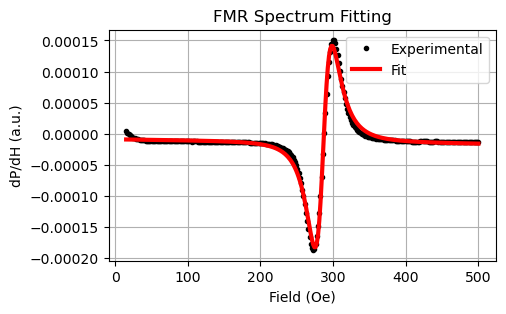

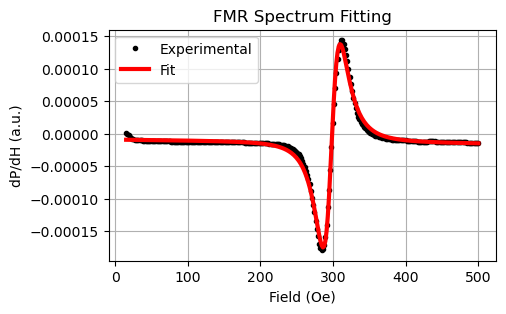

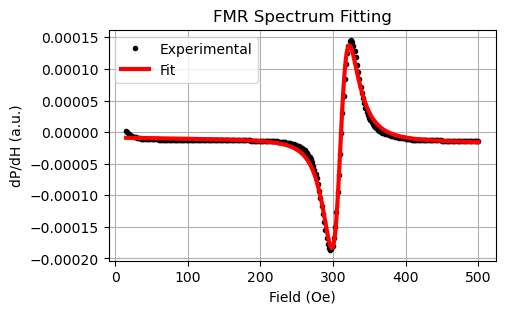

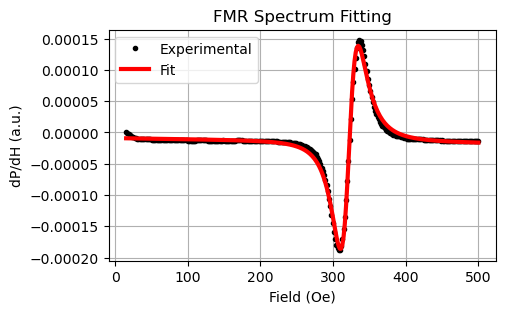

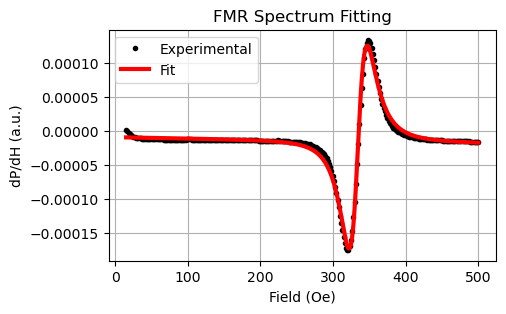

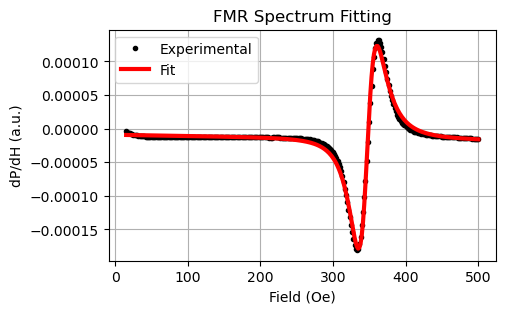

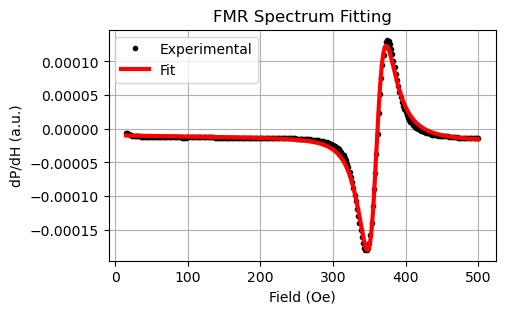

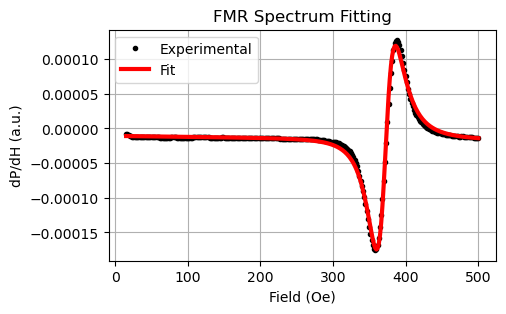

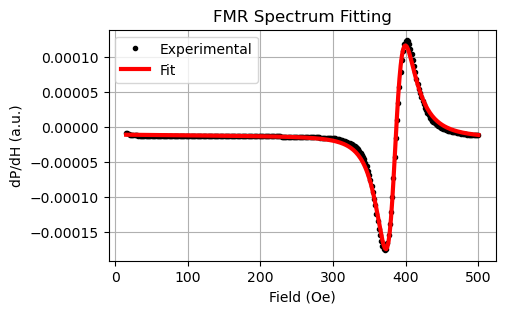

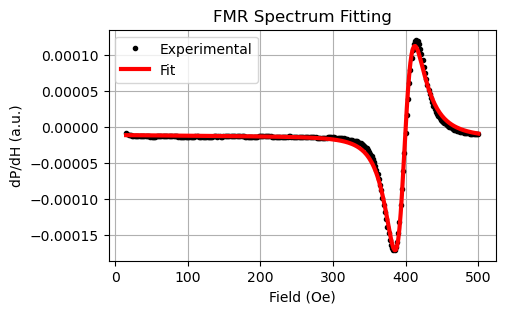

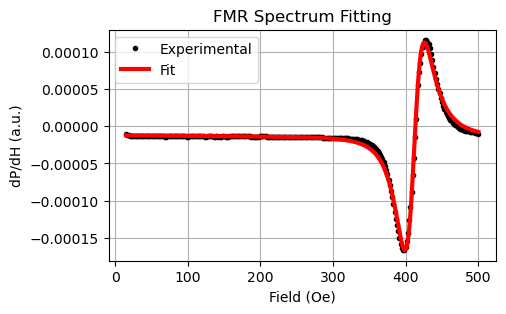

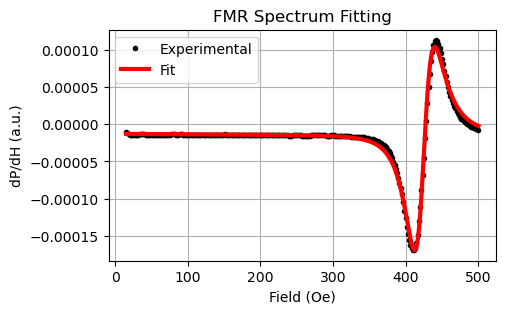

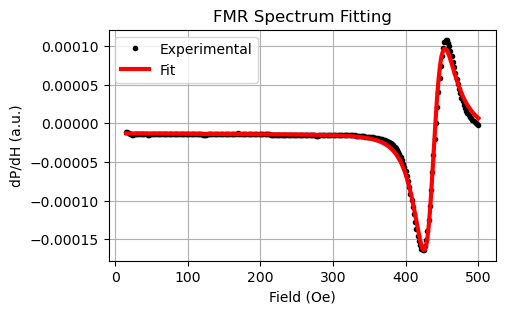

In [8]:
import numpy as np
import lmfit
import os
import pandas as pd
import matplotlib.pyplot as plt

fit = np.zeros(len(field_used))

# Create an empty DataFrame to store parameter values and uncertainties
parameter_values_df = pd.DataFrame(columns=['Frequency (GHz)', 'K1', 'K2', 'H_FMR', 'DH', 'Intercept', 'Slope'])

# Loop over frequencies
for i in range(lower_freq, len(freq_used)):
    signal = channel[i][lower_field:upper_field]
    dh = field_used[signal.argmax()] - field_used[signal.argmin()]
    K1 = (signal.max() - signal.min()) / 2 * 36 / 25 * 5 * dh**2
    K2 = 0
    H_fmr = (field_used[signal.argmin()] + field_used[signal.argmax()]) / 2

    # Create the model
    peak = dp_dh_model('pA_')
    bg = lmfit.models.LinearModel(prefix='bg_')
    model = peak + bg

    # Set initial parameters
    pars = model.make_params()
    pars['pA_K1'].set(K1)
    pars['pA_K2'].set(K2)
    pars['pA_H_FMR'].set(H_fmr)
    pars['pA_DH'].set(dh)
    pars['bg_intercept'].set(0)
    pars['bg_slope'].set(0)

    # Fit the model to your data
    fit_result = model.fit(signal, params=pars, x=field_used)

    fitX = np.linspace(field_used.min(), field_used.max(), len(field_used))
    fitY = model.eval(fit_result.params, x=fitX)
    pk1Y = model.eval(pars, x=fitX)

    fit = np.row_stack((fit, fitY))

    # Plot your data and the fit
    plt.figure(figsize=(5, 3))
    plt.plot(field_used, signal, 'ko', label='Experimental', markersize=3)
    plt.plot(fitX, fitY, 'r-', label='Fit', linewidth=3)
    plt.xlabel('Field (Oe)')
    plt.ylabel('dP/dH (a.u.)')
    plt.title(f'FMR Spectrum Fitting')
    plt.legend()
    plt.grid(True)

    # Append parameter values and uncertainties to the DataFrame
    parameter_values_df = parameter_values_df.append({
        'Frequency (GHz)': freq_used[i],
        'K1': fit_result.params['pA_K1'].value,
        'K2': fit_result.params['pA_K2'].value,
        'H_FMR': fit_result.params['pA_H_FMR'].value,
        'DH': fit_result.params['pA_DH'].value,
        'Intercept': fit_result.params['bg_intercept'].value,
        'Slope': fit_result.params['bg_slope'].value,
        'K1_Uncertainty': fit_result.params['pA_K1'].stderr,  # Add uncertainties
        'K2_Uncertainty': fit_result.params['pA_K2'].stderr,
        'H_FMR_Uncertainty': fit_result.params['pA_H_FMR'].stderr,
        'DH_Uncertainty': fit_result.params['pA_DH'].stderr,
        'Intercept_Uncertainty': fit_result.params['bg_intercept'].stderr,
        'Slope_Uncertainty': fit_result.params['bg_slope'].stderr,
    }, ignore_index=True)

    ################## CHANGE DIRECTORY HERE #####################

    output_directory = r"C:\Users\physlab\Desktop\August_data\NiFe_2Mode_R\Parameters"
    
    plot_filename = os.path.join(output_directory, f'Fitted_plot_%.2f_GHz.png' %freq[i])
    plt.savefig(plot_filename)

# Save the updated DataFrame to the existing CSV file
csv_file_path = output_directory + '\\parameter_values.csv'
parameter_values_df.to_csv(csv_file_path, index=False)

fit = fit[1:][:]

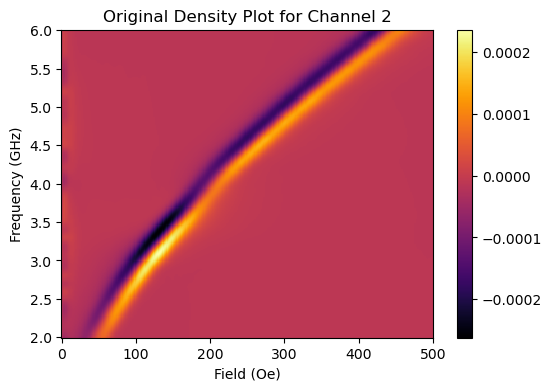

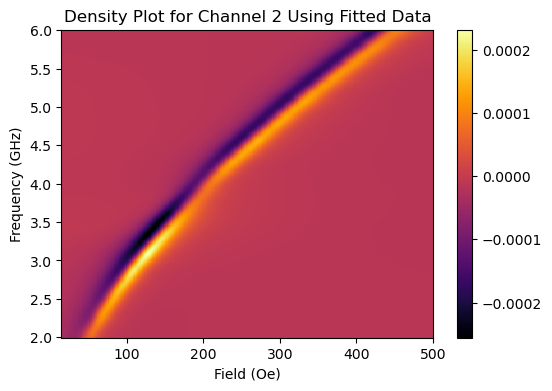

In [9]:
def filter(fil, channel):
    if fil == 'gaussian':
        smoothed_data = gaussian_filter(channel, sigma=0.7)
    elif fil == 'median':
        smoothed_data = medfilt2d(channel, kernel_size=[1,3])
    elif fil == 'spline':
        smoothed_data = spline_filter(channel, 1)
    elif fil == 'savgol':
        smoothed_data = savgol_filter(channel, 20, 10, mode='nearest')
    elif fil == 'fft':
        fft_result = np.fft.fft2(channel)
        fft_result[np.abs(fft_result) < np.percentile(np.abs(fft_result), 96)] = 0
        smoothed_data = np.fft.ifft2(fft_result).real
    elif fil == 'None':
        smoothed_data = channel
    return smoothed_data

def apply_laplacian_regularization(smoothed_data, reg_strength):
    laplacian = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    regularized_data = smoothed_data + reg_strength * convolve(smoothed_data, laplacian, mode='nearest')
    return regularized_data

def smoothed_plot(field, freq, channel, filter_type, second_filter_type='None', reg_strength=0.1):
    # Increase the number of points for a higher resolution
    n = len(field_used)
    x_new = np.linspace(field.min(), field.max(), n)
    y_new = np.linspace(freq.min(), freq.max(), n)
    field_new, freq_new = np.meshgrid(x_new, y_new)

    # Data processing
    smoothed_data = filter(filter_type, channel)
    smoothed_data = apply_laplacian_regularization(smoothed_data, reg_strength)
    smoothed_data = restoration.denoise_nl_means(smoothed_data, h=0.000001)

    if second_filter_type != 'None':
        smoothed_data = filter(second_filter_type, smoothed_data)

    # Interpolation
    interp_func = interp2d(field, freq, smoothed_data, kind='cubic')
    data = interp_func(x_new, y_new)

    # Plotting
    plt.pcolormesh(field_new, freq_new, data, cmap='inferno')
    plt.colorbar()
    plt.xlabel('Field (Oe)')
    plt.ylabel('Frequency (GHz)')

    return data

plt.figure(figsize=(6,4))
smoothed_plot(field, freq, channel2, filter_type='gaussian')
plt.title('Original Density Plot for Channel 2')
plt.show()

plt.figure(figsize=(6,4))
smoothed_plot(field_used, freq_used, fit, filter_type='savgol', second_filter_type='gaussian')
plt.title('Density Plot for Channel 2 Using Fitted Data')
plt.show()

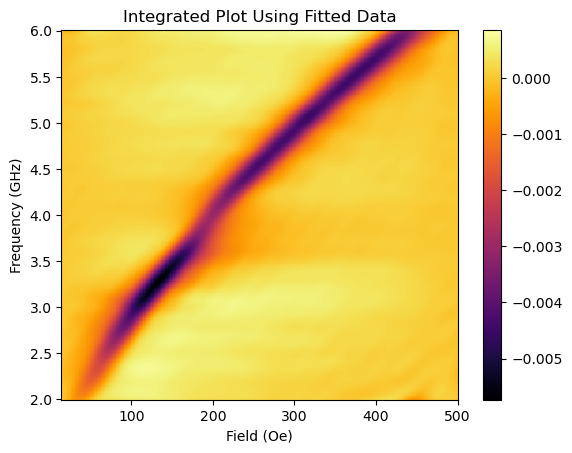

In [16]:
def integrate(xarr, varr, c=0.0):
    varr = varr - np.mean(varr)
    intg_x = np.insert(xarr, 0, xarr[0] - (xarr[1] - xarr[0]))
    intg_y = np.array([c])

    for i in range(len(xarr)):
        dydx = varr[i]
        intg_y = np.append(intg_y, dydx * (intg_x[i + 1] - intg_x[i]) + intg_y[i])
    return intg_x[1:], intg_y[1:]


Z = fit
integrated = np.zeros(Z.shape[1])

for i in range(Z.shape[0]):
    integrated = np.row_stack((integrated, integrate(field_used, Z[i])[1]))
integrated = integrated[1:]

smoothed_plot(field_used, freq_used, integrated, filter_type='fft', second_filter_type='gaussian')
plt.title('Integrated Plot Using Fitted Data')
plt.show()

# Kittel Fitting

In [11]:
from numpy import pi, sqrt

data = pd.read_csv(csv_file_path)
freq = data.iloc[:, 0]
H_FMR = data.iloc[:, 3]
line_width = data.iloc[:, 4].values

#Uncertainties in parameters
H_FMR_stderr = data.iloc[:, 9]
line_width_stderr = data.iloc[:, 10]

### SET KITTEL PARAMETERS HERE

In [12]:
H = np.linspace(0, 600, len(H_FMR)) # field range

gamma = 17.60E6/1E9 # gyromagnetic ratio
Ms = 590 # magnetic saturation
ku = 0.52  # unaxial anistropy constant
T = 20 *1E7 # thickness
Hu = 2500 #2*ku/(Ms*T) # perpendiculer anisotropy field
# ku = Hu/2 * Ms
Meff = Ms - (Hu/4*pi) # effective magnetization 
Hk = 4   # uniaxial anistropy field
Hr = 0   # rotatable anistropy field


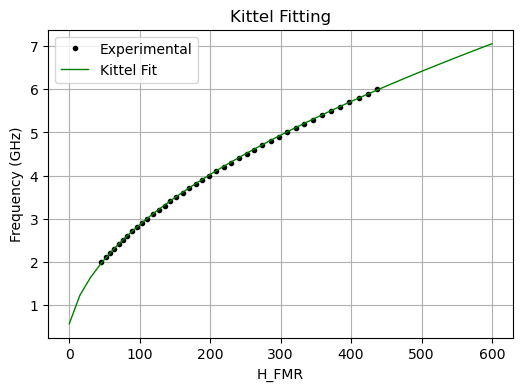

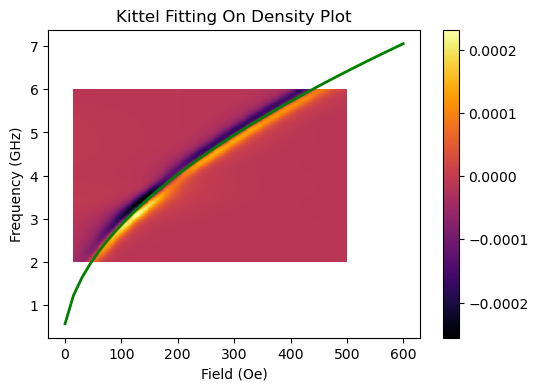

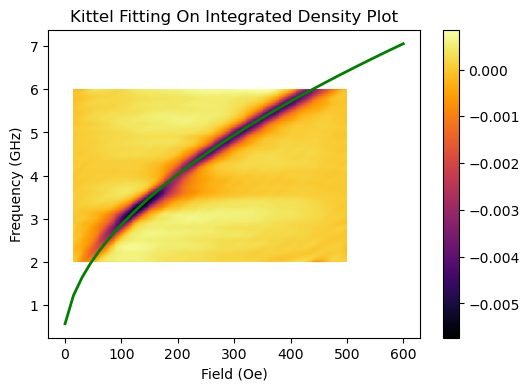

Gyromagnetic Ratio (γ): 1.76e-02 Hz/Oe
Saturation Magnetization (Ms): 5.90e+02 emu/cm^3
Effective Magnetization (Meff): -1.37e+03 emu/cm^3
Uniaxial Anistropy (ku): 0.52 erg/cm^2


In [17]:
# Kittel Equation
def kittel_equation():
    return gamma/(2*pi) * sqrt((4*pi*Ms + Hu + H + Hk + Hr) * (H + Hk + Hr))

kittel_results = kittel_equation()

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(H_FMR, freq, 'ko', markersize=3, label='Experimental')
plt.plot(H, kittel_results, 'g-', linewidth=1, label='Kittel Fit')
plt.xlabel('H_FMR')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.grid()
plt.title('Kittel Fitting')
plt.show()

plt.figure(figsize=(6,4))
smoothed_plot(field_used, freq_used, fit, filter_type='savgol', second_filter_type='gaussian')
plt.plot(H, kittel_results, 'g', linewidth=2, label='Kittel Fit')
plt.title('Kittel Fitting On Density Plot')
plt.show()

plt.figure(figsize=(6,4))
smoothed_plot(field_used, freq_used, integrated, filter_type='fft', second_filter_type='gaussian')
plt.plot(H, kittel_results, 'g', linewidth=2, label='Kittel Fit')
plt.title('Kittel Fitting On Integrated Density Plot')
plt.show()

print(f'Gyromagnetic Ratio (γ): {gamma:.2e} Hz/Oe')
print(f'Saturation Magnetization (Ms): {Ms:.2e} emu/cm^3')
print(f'Effective Magnetization (Meff): {Meff:.2e} emu/cm^3')
print(f'Uniaxial Anistropy (ku): {ku} erg/cm^2')

# Linear Fitting

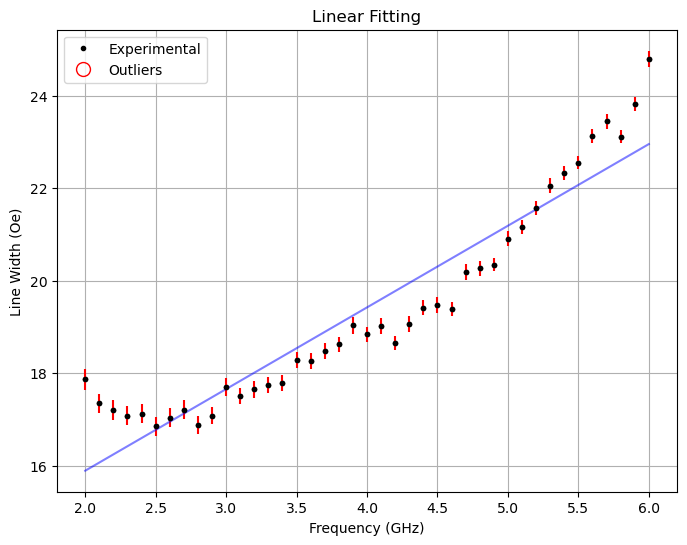

Results:

Slope: 1.7677
Intercept: 12.3520
R-squared: 0.8891
Standard Error: 0.1000
Gilbert Damping Parameter (alpha):  0.0050


In [14]:
freq = data.iloc[:, 0].values

# Linear Regression
slope, intercept, r_value, p_value, std_err = linregress(freq, line_width)

# Creating a linear fit line using the slope and intercept
fit_line = slope * freq + intercept

outlier_indices = np.where(np.abs(line_width - fit_line) > 3 * np.std(fit_line))[0]

freq_without_outliers = np.delete(freq, outlier_indices)
line_width_without_outliers = np.delete(line_width, outlier_indices)

slope, intercept, r_value, p_value, std_err = linregress(freq_without_outliers, line_width_without_outliers)
fit_line = slope * freq + intercept

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(freq, line_width, 'ko', markersize=3, label='Experimental')
plt.plot(freq[outlier_indices], line_width[outlier_indices], 'ro', 
         markersize=10, label='Outliers', markerfacecolor='none', markeredgewidth=1)
plt.errorbar(freq, line_width, line_width_stderr, fmt='o', color='black', markersize=3, ecolor='red')
plt.plot(freq, fit_line, color='blue', alpha=0.5)
plt.title('Linear Fitting')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Line Width (Oe)')
plt.legend()
plt.grid()
plt.show()

# Linear Regression Results
print('Results:\n')
print(f'Slope: {slope:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Standard Error: {std_err:.4f}')

alpha = (gamma*slope)/(2*pi)
print(f'Gilbert Damping Parameter (alpha): {alpha: .4f}')